This notebook calculates the distance between water bodies in Bangladesh and the centroid of each mauza. We calculate distances to both the closest water body, and to the Jamuna river specifically. We then join these results with the geolocated survey data so that each response now includes a distance to water and Jamuna.

In [2]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt

In [3]:
os.chdir('..')

We'll first read in the shapefiles for the river and the mauzas, and perform basic transformations to the data. 

Note that as we are interested in absolute distances, we need to be careful about the CRS that we're using. We'll switch from a geographic to a projected coordinate system, and find the appropriate UTM zone for Bangladesh. So far using [WGS84/UTM Zone 46N](https://epsg.io/32646) (although 45N would probably also be appropriate). See [Stackoverflow guidance](https://gis.stackexchange.com/questions/263427/which-projection-system-to-use-for-area-calculation-in-bangladesh-in-south-asia).

We are using the [JRC Global Surface Water layer](https://global-surface-water.appspot.com/download), clipped to our region of interest, to delineate water bodies. This dataset gives us 'permanent' water bodies (ie. where water has been present >10 months/year from Jan 2019 to Dec 2019). The [user guide](https://00f74ba44b477fd315c45aa6eaf495269b09a0e2f7-apidata.googleusercontent.com/download/storage/v1/b/global-surface-water/o/downloads_ancillary%2FDataUsersGuidev2019.pdf?jk=AFshE3WM7VMucsaiCSOcV9rqISSYWH7og55-OauSiptVFeCDHkvHvPhllAqZ8bCyTBBH5zIyUACmlB3TqoU-Y_4RH8MwUJ3X0v2RlJnvFNdqt-g8YhFSZ-gCD8EvCfQ62OHHdAM9aSN68NF0vO_KbFTETiPFXHhlloXqYB_CtMtj2FSGLaqK6ifNRjDU9VBKary2hn85nGZhatF35siO13uRo4x-zi0N1M5Ch3g0M-2vNzqUokiuFK_42HYGbiG2XtDm_ncdUBat5hyOwDGnJW5e9psl5WcqLEBzSwVQ9Awm_806G-UDjOb7TwwVl9Ou9XyXNP9TLcnkurPbhSWooJ7W6PrBE_8tBxOfyj925ejfU0NEkKfIG_MWdE2zvJSztehGEc5i55TDsGy9psRxB7K4uTlJpHHuX9DRVlOIttBNmWfi4vSyjg_9iekwlwbFPCGPANYjuK0lWqQgbyhja8uIG0vUP0tKgm7pNEYb9ZQWfsD32sEZhTubHXtn_oO4YExEQvr082_NF4PfLIdL6zvZG1s5CePvkSMQFydKdJTdiI8gJ2fd844-wkCM91n75-nNYh2aHwISMlAOmV6Ir2vsZXyftlE5MUKpd5_DaClOZOORema6ht08UCmQ9XGxoKyEZIakfgIc3cmi8qOlaSL-OMbPfIMcIWLoH9bAe9BHZ-xPDgtm6VWRSiARB6hTGmlYu0xQbJzn-lNfUzeF1jzQmBA0yxfc8d36zjg9SVVMA0o6xt_teq9tO8_lRHWrYH1L3RBdbdA5j1odBgk9y5hH-KXiTGvw4lZ-ZMvKIa6GKHtsg7kKw0BqZx31zmfA_3HwJ-OfVVXNHmp8oUrm4LAEbQuZkmZ2ktIF35d1bHytzBGU3BWgMWcl2kYCG-1Jov31LT2A9rY36q7PBY7LHfbt3R4wcr_6La8y22nn&isca=1) contains more details for this dataset. 

In [8]:
shp_river = gpd.read_file('data/GSW_Data/gsw_processed.shp').to_crs('EPSG:32646')
shp_jamuna = gpd.read_file('data/GSW_Data/gsw_processes_jamuna_estimate.shp').to_crs('EPSG:32646')
shp_adm = gpd.read_file('data/ADM_Shp/mauza/selected_distict_mauza.shp').to_crs('EPSG:32646')

We'll estimate distance using the centroid of each polygon corresponding to a union. Thus, our distances will correspond to the distance between the river and the centroid of a given union.

In [10]:
# Calculate the centroid of each union and make this the geometry for the geodataframe
shp_adm['centroid'] = shp_adm.centroid
shp_adm = shp_adm.set_geometry('centroid')

Now for each union centroid, let's calculate the distance to the closest spot on the river. 

In [11]:
# This takes a bit of time...
# We calculate the distance and get the minimum, as the river is a series of many polygons and distance is calculated to each 
shp_adm['dist_to_water'] = shp_adm['centroid'].apply(lambda x: shp_river['geometry'].distance(x).min())
shp_adm['dist_to_jamuna'] = shp_adm['centroid'].apply(lambda x: shp_jamuna['geometry'].distance(x).min())

Let's check that the distances seem appropriate by making a quick map. We'll see that the distances reach up to 60km (as UTM units are in meters), distributed in the way that we would expect.

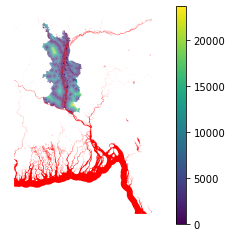

In [13]:
# Set the geometry back to the polygons and plot
shp_adm = shp_adm.set_geometry('geometry')

# Choropleth map with colour by distance, show the river in red
fig, ax = plt.subplots()
ax.set_aspect('equal')
shp_adm.plot(ax=ax, column='dist_to_water', legend=True)
shp_river.plot(ax=ax, color='red')
ax.set_axis_off()
plt.show()

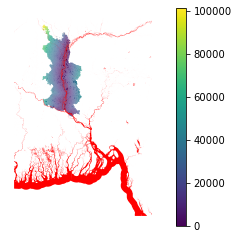

In [14]:
# Choropleth map with colour by distance, show the river in red
fig, ax = plt.subplots()
ax.set_aspect('equal')
shp_adm.plot(ax=ax, column='dist_to_jamuna', legend=True)
shp_river.plot(ax=ax, color='red')
ax.set_axis_off()
plt.show()

Now we will join these results with the geolocated survey data, so that each household entry has a column with distance to the river.

In [16]:
df_survey = pd.read_excel('data/CDP_Survey/household_locations_impactevaluation_matched.xlsx')
df_survey_dist = df_survey.merge(shp_adm.loc[:,['dist_to_water', 'dist_to_jamuna', 'OBJECTID', 'MAUZNAME']], left_on='shp_id', right_on='OBJECTID', how='left')

In [21]:
df_survey_dist.to_csv('data/CDP_Survey/household_locations_impactevaluation_matched_distance.csv')

Check to see if there's anything missing. 

In [22]:
#df_survey.isna().count()
#df_survey_dist.isna().count()